<a href="https://colab.research.google.com/github/myhousemouse/scraping_study/blob/main/tesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**라이브러리 설치**

In [2]:
# tesseract-ocr 및 한국어 팩 설치
!apt-get -y install tesseract-ocr tesseract-ocr-kor

# Python 라이브러리 설치 (pytesseract, pillow, opencv-python-headless, imutils, easyocr)
!pip install -q pytesseract pillow opencv-python-headless imutils easyocr

# 설치된 tesseract 버전 확인 (선택 사항)
!tesseract -v

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
The following NEW packages will be installed:
  tesseract-ocr-kor
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 1,052 kB of archives.
After this operation, 1,693 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-kor all 1:4.00~git30-7274cfa-1.1 [1,052 kB]
Fetched 1,052 kB in 1s (1,016 kB/s)
Selecting previously unselected package tesseract-ocr-kor.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-kor_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-kor (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-kor (1:4.00~git30-7274cfa-1.1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**구글 드라이브 불러오기 전 구글 드라이브 마운트**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 테서랙트 사용해 OCR 실행

## 테서랙트 -> 2개 이상 언어 사용시 정확도가 떨어짐, CPU사용에 특화
## EasyOCR -> 2개 이상 언어 사용시 정확도가 높음 GPU사용에 특화
## 테서랙ㅌ, EasyOCR 외에도 네이버 클로바, 구글 등 OCR 오픈소스 툴들이 많아, 만들려는 서비스에 맞춰 특화된 툴을 사용하는게 좋을듯
**참고: https://mj-thump-thump-story.tistory.com/entry/OCR-Python-%ED%99%98%EA%B2%BD%EC%97%90%EC%84%9C-Tesseract-%EC%98%88%EC%A0%9C-%EC%88%98%ED%96%89**

**참고: https://velog.io/@mminjg/TesseractOCR-EasyOCR-%EC%8B%A4%ED%96%89%EA%B3%BC-%ED%95%99%EC%8A%B5**

**OCR 사용 전 전처리 과정에서 이해를 하지못해 자꾸 오류가 나는 상황..
나중에 다시 고쳐봐야겠다**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 이미지 로드 완료


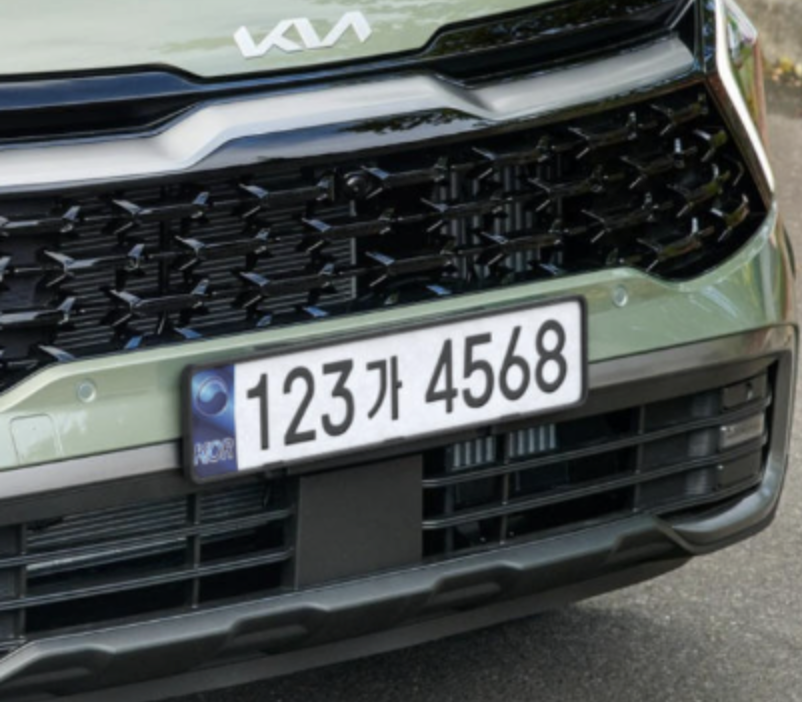

✅ Gray / Blur / Edge 결과 확인


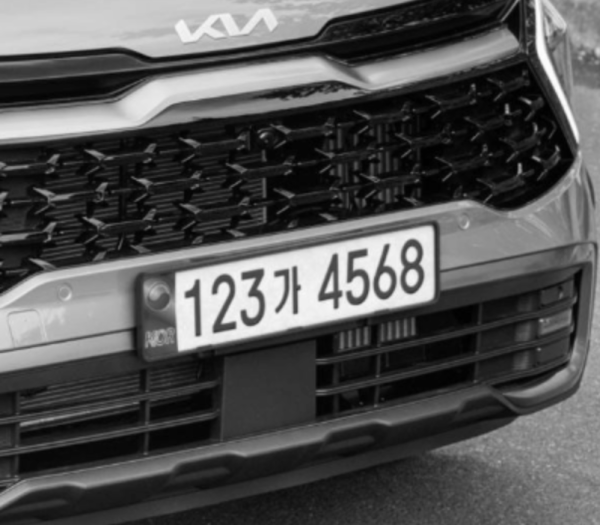

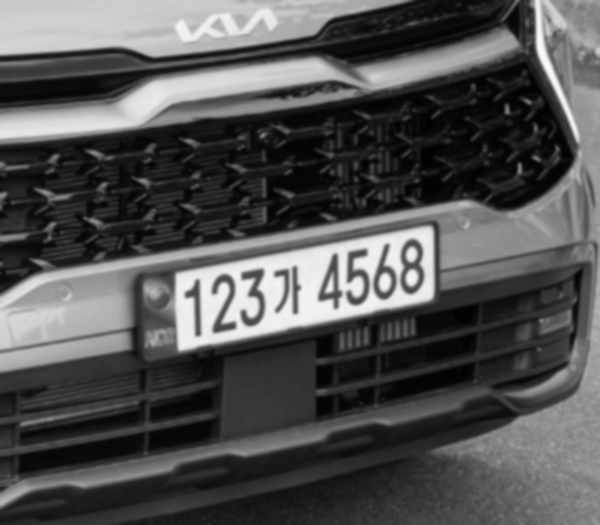

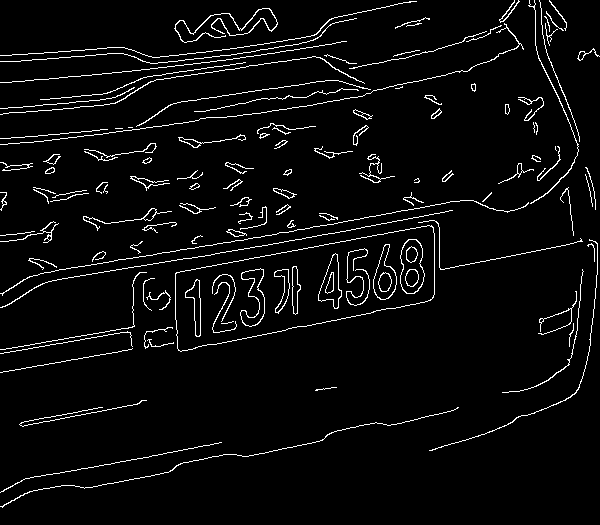

✅ 번호판 윤곽 검출 성공


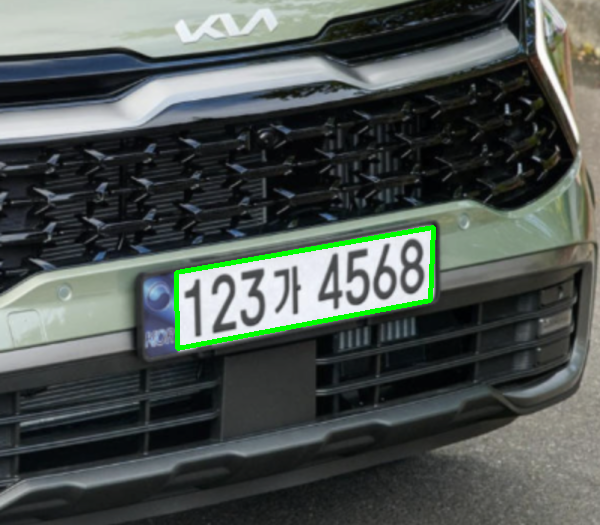

✅ 추출된 번호판 영역


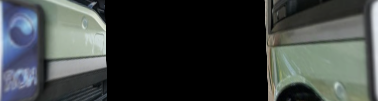

✅ 전처리(선명화/대비/확대/이진화) 결과


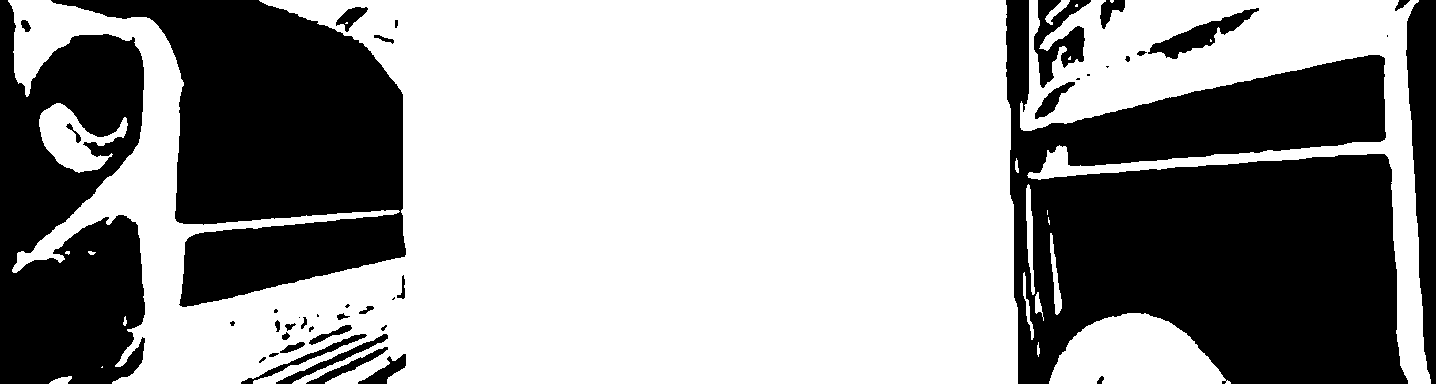

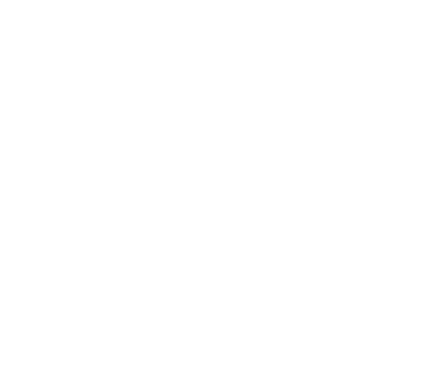


[숫자 후보] : 
[가운데 한글] : (미검출)
[조합 결과]   : (조합 실패)
⚠️ 번호판 패턴 불일치 또는 불완전 인식
   → band_ratio(0.25~0.35), 확대배율(3.8→4.5), Adaptive 블록/상수(31,5) 조정 권장


In [4]:
import cv2
import imutils
from imutils.perspective import four_point_transform
import pytesseract
import numpy as np
import re
from google.colab.patches import cv2_imshow
from google.colab import drive

# ==========================
# 1. Google Drive 마운트 및 이미지 불러오기
# ==========================
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks/test.png"
original = cv2.imread(path)

if original is None:
    raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {path}")
print("✅ 이미지 로드 완료")
cv2_imshow(original)

# ==========================
# 2. 크기 조정 + Gray 변환 + Blur + Edge 추출
# ==========================
image = imutils.resize(original, width=600)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)
edged = cv2.Canny(blurred, 75, 200)

print("✅ Gray / Blur / Edge 결과 확인")
cv2_imshow(gray)
cv2_imshow(blurred)
cv2_imshow(edged)

# ==========================
# 3. Contour 탐색 (사각형 외곽)
# ==========================
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]

plateCnt = None
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
    if len(approx) == 4:
        plateCnt = approx
        break

if plateCnt is None:
    print("❌ 번호판 윤곽을 찾지 못했습니다.")
else:
    print("✅ 번호판 윤곽 검출 성공")
    output = image.copy()
    cv2.drawContours(output, [plateCnt], -1, (0,255,0), 3)
    cv2_imshow(output)

# ==========================
# 4. 번호판 영역 추출 (Perspective Transform)
# ==========================
ratio = original.shape[1] / float(image.shape[1])
if plateCnt is not None:
    warped = four_point_transform(original, plateCnt.reshape(4, 2) * ratio)
else:
    # contour 실패 시 fallback: 중앙 하단부 crop
    h, w = original.shape[:2]
    warped = original[int(h*0.55):int(h*0.80), int(w*0.20):int(w*0.80)]

print("✅ 추출된 번호판 영역")
cv2_imshow(warped)

# ==========================
# 5. 전처리 (Sharpen + CLAHE + Resize + Otsu/Adaptive 선택 + 극성 보정)
# ==========================
from google.colab.patches import cv2_imshow
import re

# 5-1) Grayscale
gp = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

# 5-2) 언샤프 마스크로 획 선명화
sharp = cv2.addWeighted(gp, 1.6, cv2.GaussianBlur(gp, (0,0), 2.0), -0.6, 0)

# 5-3) CLAHE로 대비 향상
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enh = clahe.apply(sharp)

# 5-4) OCR 안정화를 위해 확대(글자 크기 ↑)
big = cv2.resize(enh, None, fx=3.8, fy=3.8, interpolation=cv2.INTER_CUBIC)

# 5-5) OTSU와 Adaptive 두 가지 이진화 생성
bin_otsu = cv2.threshold(big, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
bin_adap = cv2.adaptiveThreshold(big, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 31, 5)

# 5-6) 글자 에너지(검정 획) 기준으로 더 유리한 쪽 선택
def text_energy(b):
    return int(np.sum(255 - b))

binar = bin_adap if text_energy(bin_adap) > text_energy(bin_otsu) else bin_otsu

# 5-7) 극성 보정(번호판이 어두운 바탕/밝은 글자면 반전)
if np.mean(binar) < 128:   # 평균 밝기가 낮으면 글자가 밝을 가능성 → 반전
    binar = cv2.bitwise_not(binar)

print("✅ 전처리(선명화/대비/확대/이진화) 결과")
cv2_imshow(binar)

# ==========================
# 6. OCR 수행 (2패스: 숫자 전체 + 중앙 한글 단일자)
# ==========================
def normalize_num(s: str) -> str:
    s = re.sub(r"\s+", "", s)
    return s.replace("O","0").replace("I","1").replace("S","5").replace("|","1")

def normalize_kor(s: str) -> str:
    s = re.sub(r"\s+", "", s)
    return re.sub(r"[^가-힣]", "", s)

# 6-1) 숫자 전용으로 전체 라인 읽기
cfg_num = "--oem 3 --psm 7 -c preserve_interword_spaces=1 -c tessedit_char_whitelist=0123456789"
nums = pytesseract.image_to_string(binar, lang="eng", config=cfg_num)
nums = normalize_num(nums)

# 6-2) 중앙 좁은 띠(가운데 한글)만 단일 문자로 읽기
h, w = binar.shape[:2]
band_ratio = 0.30   # 필요 시 0.25~0.35로 조정
bw = int(w * band_ratio)
x1, x2 = (w - bw)//2, (w + bw)//2
mid = binar[:, x1:x2]
cv2_imshow(mid)

cfg_kor = "--oem 3 --psm 10 -c tessedit_char_whitelist=가나다라마바사아자차카타파하"
kor = pytesseract.image_to_string(mid, lang="kor", config=cfg_kor)
kor = normalize_kor(kor)[:1] if kor else ""

# 6-3) 조합 및 패턴 검증(숫자2~3 + 한글1 + 숫자4)
m = re.match(r"^(\d{2,3})(\d{4})$", nums)
candidate = f"{m.group(1)}{kor}{m.group(2)}" if (m and kor) else ""

print("\n[숫자 후보] :", nums)
print("[가운데 한글] :", kor if kor else "(미검출)")
print("[조합 결과]   :", candidate if candidate else "(조합 실패)")

pat = re.compile(r"^\d{2,3}[가-힣]\d{4}$")
if pat.match(candidate):
    print("✅ 최종 번호판 인식 성공:", candidate)
else:
    print("⚠️ 번호판 패턴 불일치 또는 불완전 인식")
    print("   → band_ratio(0.25~0.35), 확대배율(3.8→4.5), Adaptive 블록/상수(31,5) 조정 권장")

테스트1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 이미지 로드 완료


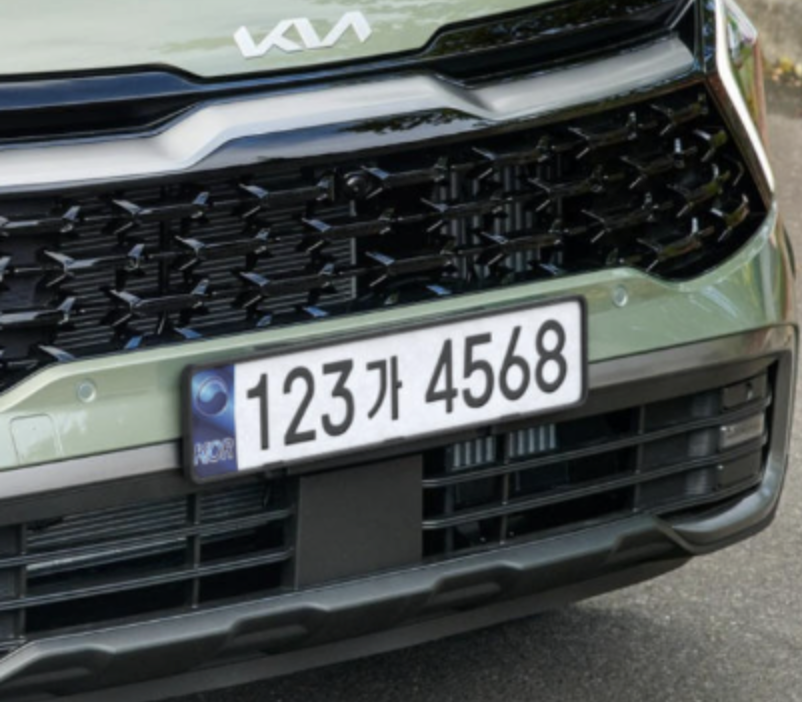

✅ 에지 결과


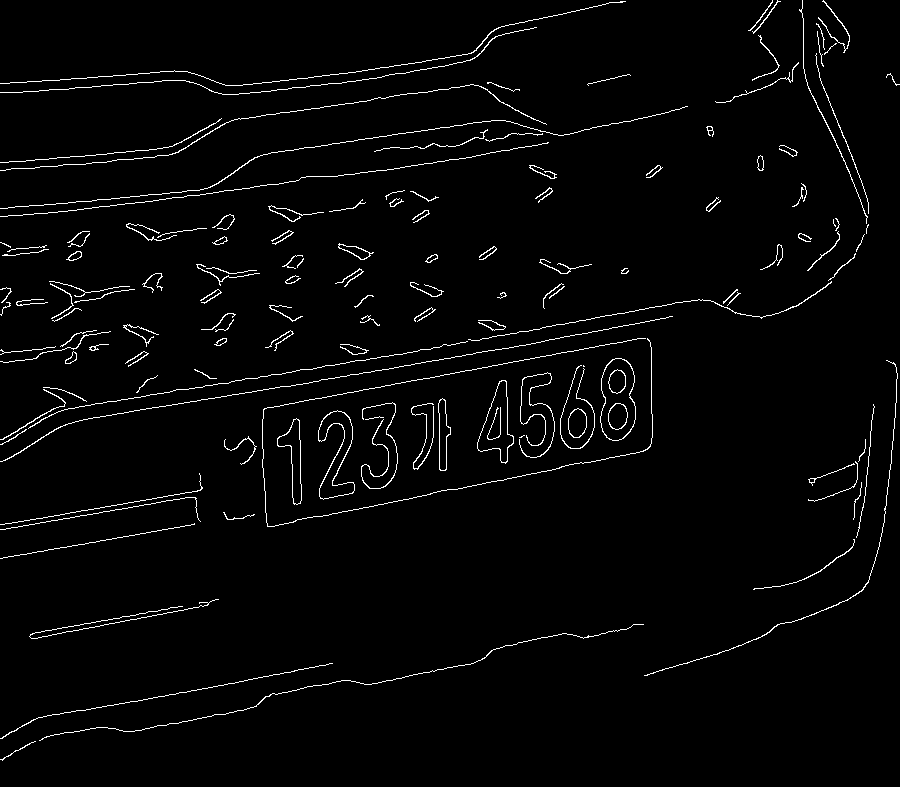

후보 수: 1
최종 선택 점수: 0.8902600480446247 | 디버그: {'S_mean': 42.96043223482609, 'V_mean': 123.79556206655556, 'text_energy': 0.6301016158587373, 'pattern_hint': 0.0, 'joined': ''}


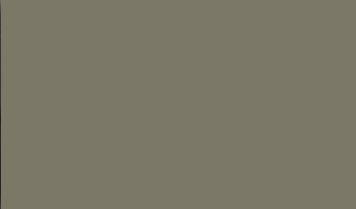


[Joined]   : 
[Filtered] : 
[Candidate]: (조합 실패)
⚠️ 보강 실패


In [10]:
# ================================
# 1) import & 드라이브 마운트 & 이미지 로드
# ================================
import cv2, imutils, pytesseract, numpy as np, re, torch, easyocr
from imutils.perspective import four_point_transform
from google.colab.patches import cv2_imshow
from google.colab import drive

drive.mount('/content/drive')

# 이미지 경로만 수정하세요
IMG_PATH = "/content/drive/MyDrive/Colab Notebooks/test.png"

original = cv2.imread(IMG_PATH)
if original is None:
    raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {IMG_PATH}")
print("✅ 이미지 로드 완료")
cv2_imshow(original)

# ================================
# 2) 다운스케일 + Gray/Blur/Edge
# ================================
image = imutils.resize(original, width=900)
gray  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur  = cv2.GaussianBlur(gray, (5,5), 0)
edge  = cv2.Canny(blur, 75, 200)

print("✅ 에지 결과")
cv2_imshow(edge)

# ==== 3) 후보 추출 (여러 개 저장) ====
cnts = cv2.findContours(edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

H, W = image.shape[:2]
img_area = H * W
raw_cands = []

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018*peri, True)
    if len(approx) != 4:
        continue
    rect = cv2.minAreaRect(c)
    (cx,cy),(rw,rh),ang = rect
    if rw == 0 or rh == 0:
        continue
    ar = max(rw, rh) / max(1.0, min(rw, rh))   # aspect ratio >= 1
    area = rw * rh
    if area < 0.01*img_area or area > 0.25*img_area:  # 너무 작거나 큼 제외
        continue
    if ar < 3.0 or ar > 6.5:                           # 번호판 비율 범위
        continue
    raw_cands.append((approx, rect, ar, area))

# 면적 큰 순으로 상위 N개만 사용 (과다 연산 방지)
raw_cands = sorted(raw_cands, key=lambda x: x[3], reverse=True)[:20]
print(f"후보 수: {len(raw_cands)}")

# ==== 4) 투시변환 유틸 ====
def order_points(pts):
    pts = np.array(pts, dtype="float32")
    rect = np.zeros((4,2), dtype="float32")
    s = pts.sum(axis=1); rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

ratio = original.shape[1] / float(image.shape[1])

def warp_from_approx(approx):
    pts = approx.reshape(4,2).astype("float32") * ratio
    rect = order_points(pts)
    try:
        warped = four_point_transform(original, rect)
        return warped
    except:
        return None

# ==== 5) 후보 점수 함수 (기하+색/밝기+텍스트+OCR 가설검증) ====
import easyocr, torch
use_gpu = torch.cuda.is_available()
reader = easyocr.Reader(['ko','en'], gpu=use_gpu)

def plate_score(wimg):
    if wimg is None or wimg.size == 0:
        return -1e9, None, {}

    # 기하 비율은 전 단계에서 걸렀으므로, 여기서는 내용 기반 점수 중심
    info = {}

    # 색/밝기: 흰판 특성(V↑, S↓)
    hsv = cv2.cvtColor(wimg, cv2.COLOR_BGR2HSV)
    S_mean = float(np.mean(hsv[:,:,1]))
    V_mean = float(np.mean(hsv[:,:,2]))
    info['S_mean'] = S_mean; info['V_mean'] = V_mean

    # 텍스트 에너지 (검은 획 에너지)
    g  = cv2.cvtColor(wimg, cv2.COLOR_BGR2GRAY)
    g  = cv2.addWeighted(g, 1.4, cv2.GaussianBlur(g,(0,0),2.0), -0.4, 0)
    big = cv2.resize(g, None, fx=2.2, fy=2.2, interpolation=cv2.INTER_CUBIC)
    binr = cv2.threshold(big, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    energy = float(np.sum(255 - binr)) / (binr.shape[0]*binr.shape[1])
    info['text_energy'] = energy

    # OCR 예비판정 (좌→우 정렬 후 패턴 근접도)
    res = reader.readtext(wimg, detail=1, paragraph=False, min_size=5,
                          low_text=0.3, text_threshold=0.4, link_threshold=0.4)
    def cx(bbox):
        pts = np.array(bbox)
        return float(np.mean(pts[:,0]))
    res = sorted(res, key=lambda r: cx(r[0]))
    joined = "".join([t for (_,t,_) in res])

    def norm_num(s):
        s = re.sub(r"\s+","",s)
        return s.replace("O","0").replace("I","1").replace("S","5").replace("|","1")
    txt = re.sub(r"[^0-9가-힣]","", norm_num(joined))

    # 패턴 근접도 점수 (숫자군/한글/숫자군 존재 여부)
    score_pat = 0.0
    if re.search(r"\d{2,3}", txt): score_pat += 1.0
    if re.search(r"[가-힣]", txt): score_pat += 1.0
    if re.search(r"\d{4}", txt):   score_pat += 1.0
    info['pattern_hint'] = score_pat
    info['joined'] = txt

    # 종합 스코어 (가중합) - 값은 경험적으로 조정
    score = 0.8*(V_mean/255.0) + 0.6*(1.0 - S_mean/255.0) + 1.2*(energy/255.0) + 1.5*score_pat
    return score, res, info


# ==== 6) 모든 후보에 대해 warp+score → 최고 득점 채택 ====
best = (-1e9, None, None, None)  # (score, warped, ocr_res, debug_info)
for approx, rect, ar, area in raw_cands:
    wimg = warp_from_approx(approx)
    sc, ocr_res, dbg = plate_score(wimg)
    if sc > best[0]:
        best = (sc, wimg, ocr_res, dbg)

score, warped_best, ocr_best, dbg = best
if warped_best is None:
    # 최종 폴백: 하단 대략 크롭
    h0, w0 = original.shape[:2]
    warped_best = original[int(h0*0.55):int(h0*0.80), int(w0*0.20):int(w0*0.80)]
    print("후보 실패 → 폴백 ROI 사용")

print("최종 선택 점수:", score, "| 디버그:", dbg)
cv2_imshow(warped_best)


# ==== 7) 최종 OCR 후처리(한국 번호판 패턴으로 조립) ====
def cx(bbox):
    pts = np.array(bbox)
    return float(np.mean(pts[:,0]))

res_sorted = sorted(ocr_best, key=lambda r: cx(r[0])) if ocr_best else []
joined = "".join([t for (_,t,_) in res_sorted]) if res_sorted else ""

def norm_num(s):
    s = re.sub(r"\s+","",s)
    return s.replace("O","0").replace("I","1").replace("S","5").replace("|","1")

joined_kor = re.sub(r"[^0-9가-힣]","", norm_num(joined))
m = re.search(r"(\d{2,3}).*?([가-힣]).*?(\d{4})", joined_kor)
candidate = f"{m.group(1)}{m.group(2)}{m.group(3)}" if m else ""

print("\n[Joined]   :", joined)
print("[Filtered] :", joined_kor)
print("[Candidate]:", candidate if candidate else "(조합 실패)")

final_pat = re.compile(r"^\d{2,3}[가-힣]\d{4}$")
if final_pat.match(candidate):
    print("✅ 최종 번호판:", candidate)
else:
    # 중앙 한글 보강 조합
    H2, W2 = warped_best.shape[:2]
    kor_cands = []
    for (bbox, text, conf) in res_sorted:
        k = re.sub(r"[^가-힣]","", text)
        if k:
            cx_ = float(np.mean(np.array(bbox)[:,0]))
            kor_cands.append((abs(cx_ - W2/2), k[0]))
    kor_cands.sort(key=lambda x: x[0])

    digits = "".join([re.sub(r"[^0-9]","", norm_num(t)) for (_,t,_) in res_sorted])
    m2 = re.search(r"(\d{2,3}).*?(\d{4})", digits)
    if kor_cands and m2:
        candidate2 = f"{m2.group(1)}{kor_cands[0][1]}{m2.group(2)}"
        if final_pat.match(candidate2):
            print("✅ 보강 재조합 성공:", candidate2)
        else:
            print("⚠️ 패턴 불일치:", candidate2)
    else:
        print("⚠️ 보강 실패")


테스트2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 이미지 로드 완료


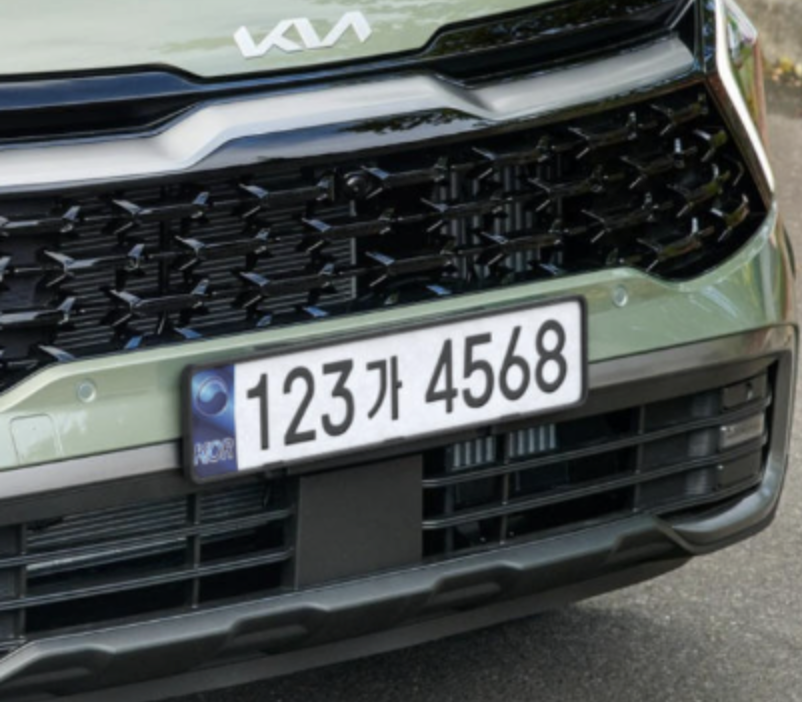

✅ Gray / Blur / Edge 결과 확인


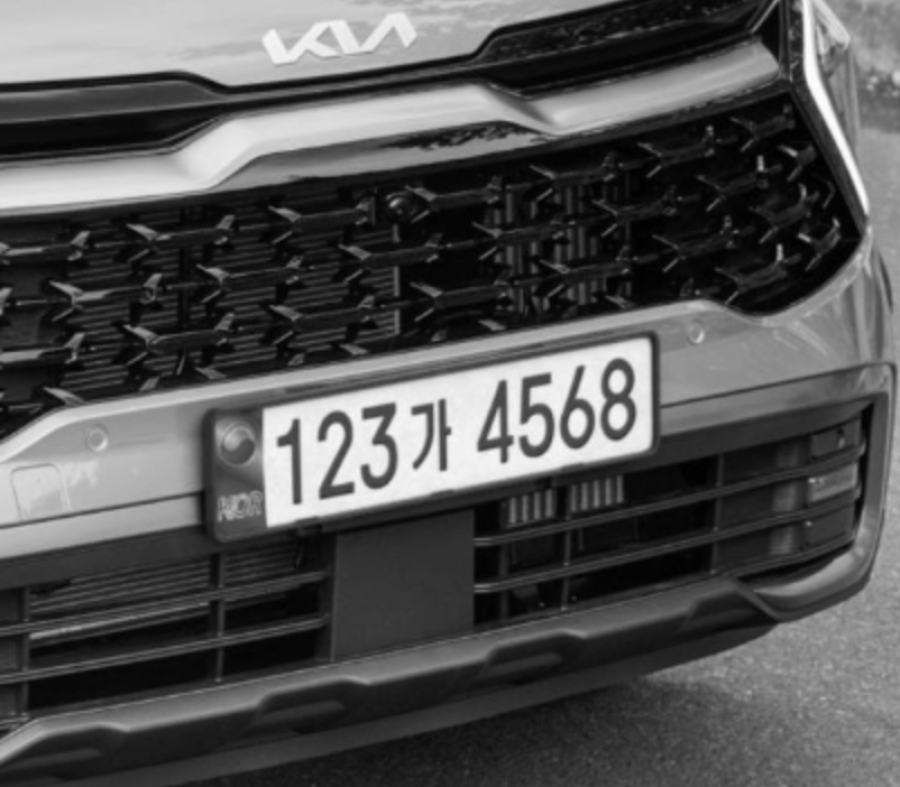

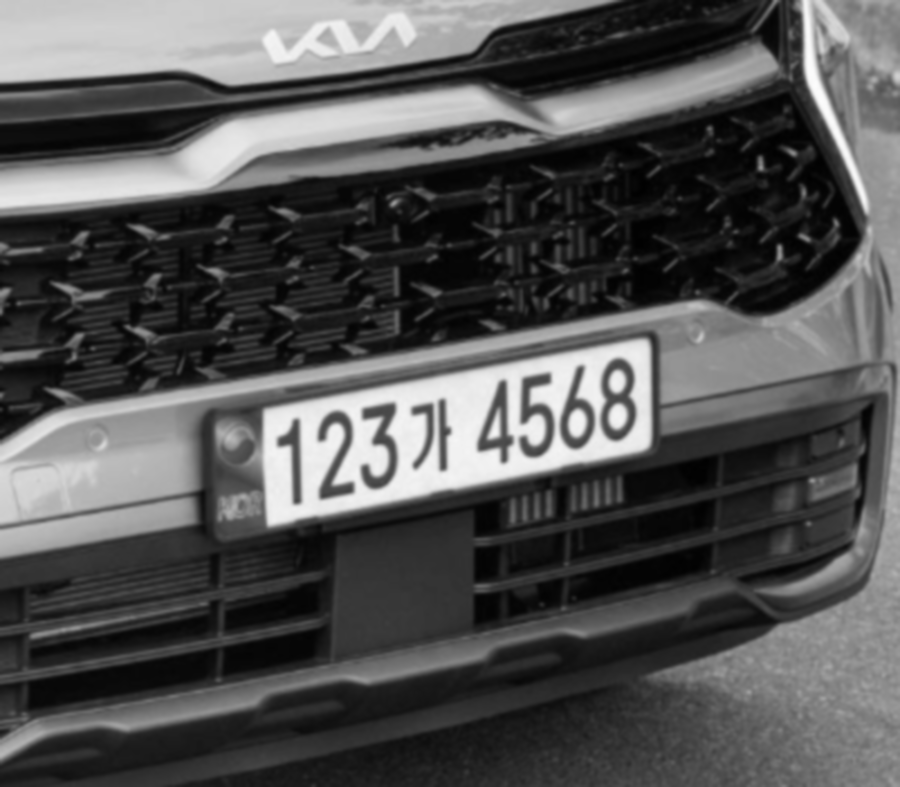

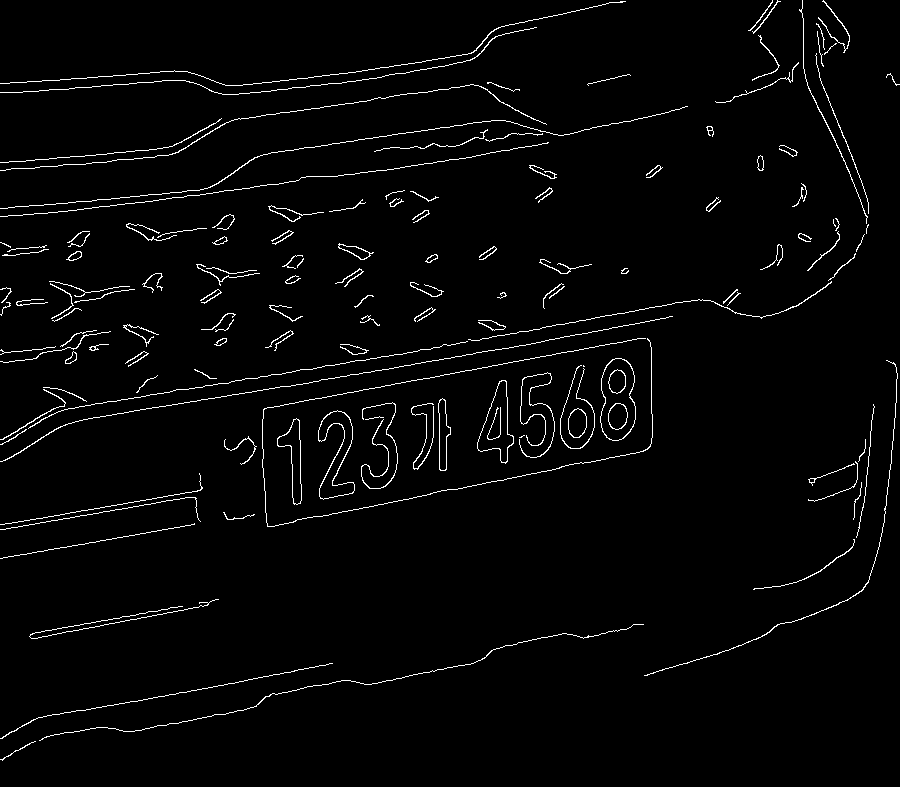

후보 수: 1
  후보 점수: 0.661 | AR: 3.30 | Area: 48498 | Debug: {'S_mean': 42.96043223482609, 'V_mean': 123.79556206655556, 'color_score': 0.6585002545720186, 'text_energy': 0.7128648997365733, 'text_energy_score': 0.0027955486264179346, 'pattern_hint': 0.0, 'joined_ocr': '', 'raw_ocr_results': []}
  Fallback 점수: 2.009 | Debug: {'S_mean': 47.06930798930799, 'V_mean': 80.2689515889516, 'color_score': 0.5650973403914581, 'text_energy': 77.58604098604098, 'text_energy_score': 0.30425898425898423, 'pattern_hint': 2.0, 'joined_ocr': '412479', 'raw_ocr_results': [([[np.int32(28), np.int32(52)], [np.int32(68), np.int32(52)], [np.int32(68), np.int32(84)], [np.int32(28), np.int32(84)]], '4', np.float64(0.639074526859762)), ([[np.int32(73), 0], [np.int32(269), 0], [np.int32(269), np.int32(83)], [np.int32(73), np.int32(83)]], '124', np.float64(0.2901716018058534)), ([[np.int32(255), 0], [np.int32(433), 0], [np.int32(433), np.int32(39)], [np.int32(255), np.int32(39)]], '79', np.float64(0.3257895358174842

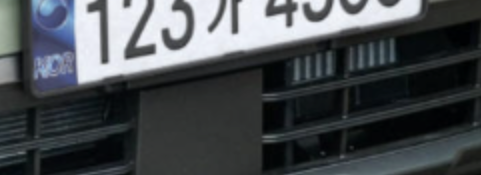


--- 최종 선택 영역 OCR 결과 ---
✅ 최종 선택 영역 전처리 결과 (CLAHE + Sharpened)


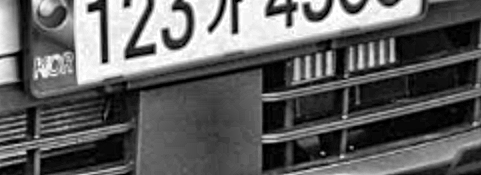

✅ EasyOCR final results:
  text='나9마', conf=0.139, bbox=[[np.int32(259), 0], [np.int32(425), 0], [np.int32(425), np.int32(35)], [np.int32(259), np.int32(35)]]
  text='4', conf=0.402, bbox=[[np.int32(30), np.int32(52)], [np.int32(64), np.int32(52)], [np.int32(64), np.int32(82)], [np.int32(30), np.int32(82)]]
  text='121', conf=0.646, bbox=[[np.int32(75), 0], [np.int32(263), 0], [np.int32(263), np.int32(77)], [np.int32(75), np.int32(77)]]
✅ 최종 인식 박스 시각화


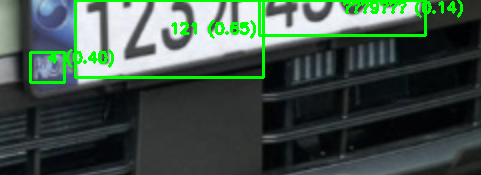


--- 최종 후처리 디버그 ---
Final results sorted: [([[np.int32(30), np.int32(52)], [np.int32(64), np.int32(52)], [np.int32(64), np.int32(82)], [np.int32(30), np.int32(82)]], '4', np.float64(0.4015580298291752)), ([[np.int32(75), 0], [np.int32(263), 0], [np.int32(263), np.int32(77)], [np.int32(75), np.int32(77)]], '121', np.float64(0.6463134419627186)), ([[np.int32(259), 0], [np.int32(425), 0], [np.int32(425), np.int32(35)], [np.int32(259), np.int32(35)]], '나9마', np.float64(0.13866722716377367))]
Filtered Number candidates: [{'text': '121', 'conf': np.float64(0.6463134419627186), 'bbox': [[np.int32(75), 0], [np.int32(263), 0], [np.int32(263), np.int32(77)], [np.int32(75), np.int32(77)]], 'cx': 169.0, 'cy': np.float64(38.5)}]
Filtered Korean candidates: []

❌ 번호판 인식 실패 (후보 조합 실패)


In [19]:
import cv2
import imutils
from imutils.perspective import four_point_transform
import pytesseract
import numpy as np
import re
from google.colab.patches import cv2_imshow
from google.colab import drive

# ==========================
# 1. Google Drive 마운트 및 이미지 불러오기
# ==========================
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks/test.png"  # 실제 경로 확인 필요
original = cv2.imread(path)

if original is None:
    raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {path}")
print("✅ 이미지 로드 완료")
cv2_imshow(original)

# ==========================
# 2. 크기 조정 + Gray 변환 + Blur + Edge 추출
# ==========================
# 이미지 리사이즈 크기를 조금 더 키워 윤곽선 탐지 정확도 향상 시도
image = imutils.resize(original, width=900) # width 600 -> 900으로 변경
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)
edged = cv2.Canny(blurred, 75, 200)

print("✅ Gray / Blur / Edge 결과 확인")
cv2_imshow(gray)
cv2_imshow(blurred)
cv2_imshow(edged)

# ==========================
# 3. Contour 탐색 및 후보 영역 추출 (Score 기반)
# ==========================
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

H, W = image.shape[:2]
img_area = H * W
raw_cands = [] # 사각형 후보들을 저장할 리스트

# 3-1) 사각형 윤곽선 탐지 및 필터링
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018*peri, True)
    if len(approx) != 4: # 사각형이 아니면 건너뛰기
        continue
    rect = cv2.minAreaRect(c)
    (cx,cy),(rw,rh),ang = rect
    if rw == 0 or rh == 0: # 유효하지 않은 사각형 건너뛰기
        continue
    ar = max(rw, rh) / max(1.0, min(rw, rh))   # aspect ratio >= 1 계산
    area = rw * rh # 면적 계산
    # 면적 및 가로/세로 비율로 번호판 후보 필터링 (값 조정 가능)
    if area < 0.005*img_area or area > 0.30*img_area: # 너무 작거나 큼 제외 (면적 범위 조정)
        continue
    if ar < 2.5 or ar > 7.0: # 번호판 비율 범위 (비율 범위 조정)
        continue
    raw_cands.append((approx, rect, ar, area))

# 면적 큰 순으로 상위 N개만 사용 (과다 연산 방지)
raw_cands = sorted(raw_cands, key=lambda x: x[3], reverse=True)[:20]
print(f"후보 수: {len(raw_cands)}")

# 3-2) 투시변환 유틸리티 함수 (QSqVOeaPA-Jp 셀에서 가져옴)
def order_points(pts):
    pts = np.array(pts, dtype="float32")
    rect = np.zeros((4,2), dtype="float32")
    s = pts.sum(axis=1); rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

ratio = original.shape[1] / float(image.shape[1]) # 원본 대비 리사이즈 비율

def warp_from_approx(approx):
    # 투시 변환 전 points order 확인 및 변환
    pts = approx.reshape(4,2).astype("float32") * ratio
    rect_ordered = order_points(pts)
    try:
        warped = four_point_transform(original, rect_ordered)
        return warped
    except Exception as e:
        print(f"투시 변환 오류: {e}")
        return None

# 3-3) 후보 영역 점수 함수 (QSqVOeaPA-Jp 셀에서 가져와 수정)
# EasyOCR reader 초기화는 이미 5번 단계에 있으므로 여기서 다시 하지 않음

def plate_score(wimg, reader_instance): # reader 인스턴스를 파라미터로 받음
    if wimg is None or wimg.size == 0 or wimg.shape[0] < 10 or wimg.shape[1] < 10: # 최소 크기 체크
        return -1e9, None, {}

    # 기하 비율은 전 단계에서 걸렀으므로, 여기서는 내용 기반 점수 중심
    info = {}

    # 색/밝기: 흰판 특성(V↑, S↓) 점수 (가중치 조정 가능)
    try: # 예외 처리 추가
        hsv = cv2.cvtColor(wimg, cv2.COLOR_BGR2HSV)
        S_mean = float(np.mean(hsv[:,:,1]))
        V_mean = float(np.mean(hsv[:,:,2]))
        # V가 높고 S가 낮을수록 점수 높게 (흰색 번호판 특징)
        color_score = 0.5 * (V_mean/255.0) + 0.5 * (1.0 - S_mean/255.0)
        info['S_mean'] = S_mean; info['V_mean'] = V_mean; info['color_score'] = color_score
    except Exception as e:
        print(f"색/밝기 점수 계산 오류: {e}"); color_score = -1.0 # 오류 시 낮은 점수 부여

    # 텍스트 에너지 (검은 획 에너지) 점수 (가중치 조정 가능)
    try: # 예외 처리 추가
        g  = cv2.cvtColor(wimg, cv2.COLOR_BGR2GRAY)
        # 대비 향상 (EasyOCR 내장 전처리에도 도움)
        g = cv2.addWeighted(g, 1.5, cv2.GaussianBlur(g,(0,0),2.0), -0.5, 0)
        # 이진화 후 검은 픽셀 비율로 에너지 계산
        # 적응형 이진화나 OTSU 모두 시도 가능, 여기서는 간단히 하나 사용
        binr = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 4)
        energy = float(np.sum(255 - binr)) / (binr.shape[0]*binr.shape[1])
        text_energy_score = energy / 255.0 # 정규화
        info['text_energy'] = energy; info['text_energy_score'] = text_energy_score
    except Exception as e:
        print(f"텍스트 에너지 계산 오류: {e}"); text_energy_score = -1.0 # 오류 시 낮은 점수 부여


    # OCR 예비판정 (좌→우 정렬 후 패턴 근접도) 점수 (가중치 조정 가능)
    # 신뢰도 임계값을 낮춰서 더 많은 텍스트 후보 확보
    try: # 예외 처리 추가
        res = reader_instance.readtext(wimg, detail=1, paragraph=False, min_size=5,
                                      low_text=0.2, text_threshold=0.3, link_threshold=0.3, # 임계값 완화
                                      allowlist='0123456789가나다라마바사아자차카타파하') # 화이트리스트
        def cx(bbox):
            pts = np.array(bbox)
            return float(np.mean(pts[:,0]))
        res = sorted(res, key=lambda r: cx(r[0]))
        joined = "".join([t for (_,t,_) in res])

        def norm_num(s):
            s = re.sub(r"\s+","",s)
            return s.replace("O","0").replace("I","1").replace("S","5").replace("|","1")
        txt = re.sub(r"[^0-9가-힣]","", norm_num(joined))

        # 패턴 근접도 점수 (숫자군/한글/숫자군 존재 여부) - 이전보다 덜 엄격하게
        score_pat = 0.0
        if re.search(r"\d{1,3}", txt): score_pat += 1.0 # 숫자 1~3자리만 있어도 힌트
        if re.search(r"[가-힣]", txt): score_pat += 1.0 # 한글 1개 힌트
        if re.search(r"\d{3,4}", txt):   score_pat += 1.0 # 숫자 3~4자리 힌트
        # 최종 패턴 매치 시 추가 점수
        if re.search(r"^\d{2,3}[가-힣]\d{4}$", txt): score_pat += 2.0

        info['pattern_hint'] = score_pat
        info['joined_ocr'] = txt
        info['raw_ocr_results'] = res
        ocr_score = score_pat / 5.0 # 최대 점수 5.0으로 가정하여 정규화
    except Exception as e:
        print(f"OCR 예비판정 오류: {e}"); ocr_score = -1.0 # 오류 시 낮은 점수 부여
        info['raw_ocr_results'] = []


    # 종합 스코어 (가중합) - 값은 경험적으로 조정
    # OCR 결과에 더 높은 가중치 부여
    score = 1.0*color_score + 0.8*text_energy_score + 3.0*ocr_score
    return score, info['raw_ocr_results'], info


# ==== 5. EasyOCR 설치 및 리더 초기화 (GPU 자동 감지) ====
# 이미 노트북 상단에서 실행된 것으로 가정
# import easyocr, torch
# use_gpu = torch.cuda.is_available()
# reader = easyocr.Reader(['ko','en'], gpu=use_gpu) # 여기서는 전역 reader 사용

# reader 인스턴스 재사용 또는 초기화 (필요시)
try:
    reader
except NameError:
    import easyocr, torch
    use_gpu = torch.cuda.is_available()
    print(f"✅ EasyOCR 리더 초기화 (GPU 사용 여부): {use_gpu}")
    reader = easyocr.Reader(['ko','en'], gpu=use_gpu)


# ==== 6) 모든 후보에 대해 warp+score → 최고 득점 채택 ====
best = (-1e9, None, None, None)  # (score, warped_img, ocr_res, debug_info)
fallback_warped = None # 후보 탐지 실패 시 사용할 fallback 이미지

for approx, rect, ar, area in raw_cands:
    wimg = warp_from_approx(approx)
    if wimg is not None and wimg.size > 0:
        sc, ocr_res, dbg = plate_score(wimg, reader) # 초기화된 reader 사용
        print(f"  후보 점수: {sc:.3f} | AR: {ar:.2f} | Area: {area:.0f} | Debug: {dbg}")
        if sc > best[0]:
            best = (sc, wimg, ocr_res, dbg)

# 후보 탐지 및 점수 계산에 실패했을 경우 대비한 fallback 이미지 생성
# 원본 이미지에서 미리 정의된 하단 영역을 잘라냄
h0, w0 = original.shape[:2]
fallback_warped = original[int(h0*0.55):int(h0*0.80), int(w0*0.20):int(w0*0.80)]

# 만약 후보 중에서 유효한 이미지를 찾지 못했거나, fallback 점수가 더 높을 경우 fallback 사용
fallback_sc, fallback_ocr_res, fallback_dbg = plate_score(fallback_warped, reader)
print(f"  Fallback 점수: {fallback_sc:.3f} | Debug: {fallback_dbg}")


# 최종 선택: 후보 중 최고 점수 vs Fallback 점수 비교
if best[1] is None or fallback_sc > best[0]:
    warped_best = fallback_warped
    ocr_best = fallback_ocr_res
    dbg = fallback_dbg
    score = fallback_sc
    print("후보 실패 또는 Fallback 우세 → Fallback ROI 사용")
else:
    warped_best = best[1]
    ocr_best = best[2]
    dbg = best[3]
    score = best[0]
    print("최고 점수 후보 ROI 사용")

print("최종 선택 점수:", score, "| 디버그:", dbg)
cv2_imshow(warped_best)


# ==========================
# 6. 최종 EasyOCR로 인식 (선택된 최적 이미지 사용)
# ==========================
# 이미 5번 단계의 plate_score 함수 내에서 OCR 예비 판정이 수행되었지만,
# 최종 선택된 warped_best 이미지로 다시 한번 명확하게 OCR 수행 및 시각화
print("\n--- 최종 선택 영역 OCR 결과 ---")

# --- 전처리 추가 --- (plate_score 함수 내와 동일 또는 유사)
# 1. 그레이스케일 변환
warped_gray = cv2.cvtColor(warped_best, cv2.COLOR_BGR2GRAY)

# 2. 대비 향상 (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
warped_enhanced = clahe.apply(warped_gray)

# 3. 선명도 강화 (Unsharp Masking 효과)
blurred = cv2.GaussianBlur(warped_enhanced, (0,0), 2.0)
warped_sharpened = cv2.addWeighted(warped_enhanced, 2.0, blurred, -1.0, 0)

print("✅ 최종 선택 영역 전처리 결과 (CLAHE + Sharpened)")
cv2_imshow(warped_sharpened)

# EasyOCR 실행 (plate_score에서 사용한 임계값보다 조금 더 엄격하거나 동일하게 설정 가능)
final_results = reader.readtext(
    warped_sharpened,
    detail=1,
    paragraph=False,
    min_size=5,
    low_text=0.3, # 약간 엄격하게
    text_threshold=0.4,
    link_threshold=0.4,
    allowlist='0123456789가나다라마바사아자차카타파하'
)

vis = warped_best.copy()
H_best, W_best = vis.shape[:2]


print("✅ EasyOCR final results:")
for (bbox, text, conf) in final_results:
    print(f"  text={text!r}, conf={conf:.3f}, bbox={bbox}")
    # 시각화
    pts = np.array(bbox).astype(int)
    cv2.polylines(vis, [pts], True, (0,255,0), 2)
    cx = int(np.mean(pts[:,0])); cy = int(np.mean(pts[:,1]))
    # 신뢰도 표시
    cv2.putText(vis, f"{text} ({conf:.2f})", (cx, max(0,cy-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

print("✅ 최종 인식 박스 시각화")
cv2_imshow(vis)


# ==========================
# 7. 최종 후처리: 한국 번호판 패턴으로 정규화/조립 (강화된 로직)
# ==========================
def norm_num(s: str) -> str:
    s = re.sub(r"\s+", "", s)
    return (s.replace("O","0").replace("I","1").replace("S","5").replace("|","1").replace("L","1").replace("l","1")) # L, l 추가

def only_kor(s: str) -> str:
    return re.sub(r"[^가-힣]", "", s)

# 7-1) 좌→우로 정렬
def bbox_center_x(bbox):
    pts = np.array(bbox)
    return float(np.mean(pts[:,0]))

results_sorted_final = sorted(final_results, key=lambda r: bbox_center_x(r[0]))

print("\n--- 최종 후처리 디버그 ---")
print(f"Final results sorted: {results_sorted_final}")

# 7-2) 숫자 및 한글 후보 수집 (위치, 신뢰도 기반 필터링 강화)
num_candidates = []
kor_candidates = []

# 번호판 중앙 Y 좌표 대략 계산 (bbox y 중앙값들의 평균)
center_y_list = [ (np.mean(np.array(r[0])[:,1]), r[2]) for r in results_sorted_final ]
if center_y_list:
    # 신뢰도 높은 bbox들의 y 중앙값 평균 사용
    center_y = np.mean([cy for cy, conf in center_y_list if conf > 0.5])
else:
    center_y = H_best / 2.0 # 후보 없을 시 이미지 중앙 사용


for (bbox, text, conf) in results_sorted_final:
    cleaned_text = norm_num(text)
    cx = bbox_center_x(bbox)
    cy = np.mean(np.array(bbox)[:,1])
    bbox_height = np.max(np.array(bbox)[:,1]) - np.min(np.array(bbox)[:,1])
    img_height = H_best

    # 후보 필터링 기준 강화
    # - 신뢰도 임계값 (조정 가능)
    # - bbox의 세로 중심이 번호판 중앙 Y 근처에 있는지 (수직 정렬 확인)
    # - bbox 높이가 너무 작거나 크지 않은지 (글자 크기 유사성 확인)

    is_valid_candidate = (conf > 0.4) and \
                         (abs(cy - center_y) < img_height * 0.25) and \
                         (bbox_height > img_height * 0.2) and (bbox_height < img_height * 0.7)


    if is_valid_candidate:
        # 숫자 후보 추출
        nums = re.findall(r'\d+', cleaned_text)
        for num in nums:
            if len(num) > 0:
                 num_candidates.append({'text': num, 'conf': conf, 'bbox': bbox, 'cx': cx, 'cy': cy})

        # 한글 후보 추출
        kors = only_kor(text)
        if len(kors) == 1:
            kor_candidates.append({'text': kors[0], 'conf': conf, 'bbox': bbox, 'cx': cx, 'cy': cy})

print(f"Filtered Number candidates: {num_candidates}")
print(f"Filtered Korean candidates: {kor_candidates}")


candidate = ""
best_candidate = None
best_score = -1

# 7-3) 숫자 그룹과 한글 후보를 조합하여 가능한 번호판 패턴 찾기
# (숫자 2~3자리) + (한글 1글자) + (숫자 4자리)
# 모든 유효 한글 후보에 대해 가장 가까운 왼쪽/오른쪽 유효 숫자 그룹을 찾아 조합 시도

final_pat = re.compile(r"^\d{2,3}[가-힣]\d{4}$")

if kor_candidates:
    # 한글 후보를 중앙과의 거리가 가까운 순으로 정렬
    kor_candidates.sort(key=lambda x: abs(x['cx'] - W_best/2))

    for kor_cand in kor_candidates:
        kor_cx = kor_cand['cx']

        # 한글 왼쪽에 있는 유효 숫자 후보 찾기 (가장 가까운 1개)
        left_nums = [n for n in num_candidates if n['cx'] < kor_cx]
        left_nums.sort(key=lambda x: x['cx'], reverse=True) # 오른쪽에서 가까운 순 (즉, 한글에 가장 가까운 왼쪽)

        # 한글 오른쪽에 있는 유효 숫자 후보 찾기 (가장 가까운 1개)
        right_nums = [n for n in num_candidates if n['cx'] > kor_cx]
        right_nums.sort(key=lambda x: x['cx']) # 왼쪽에서 가까운 순 (즉, 한글에 가장 가까운 오른쪽)

        # 왼쪽/오른쪽 숫자 후보가 각각 하나씩이라도 있어야 조합 시도
        if left_nums and right_nums:
            left_part = left_nums[0]['text']
            right_part = right_nums[0]['text']
            kor_part = kor_cand['text']

            # 간단한 조합 시도: 왼쪽 숫자 중 2~3자리 + 한글 + 오른쪽 숫자 중 4자리
            # 왼쪽 부분은 여러 숫자가 이어져 있을 수 있으므로 패턴 매치 시도
            m_left = re.search(r'\d{2,3}$', left_part) # 왼쪽 숫자 끝에서 2~3자리 탐색
            m_right = re.search(r'^\d{4}', right_part) # 오른쪽 숫자 앞에서 4자리 탐색

            if m_left and m_right:
                left_final = m_left.group(0)
                right_final = m_right.group(0)

                temp_candidate = f"{left_final}{kor_part}{right_final}"

                # 조합된 패턴이 번호판 형식에 맞는지 최종 확인
                if final_pat.match(temp_candidate):
                    print(f"  조합 성공 시도: {temp_candidate} (패턴 일치)")
                    # 간단한 점수 계산 (사용된 후보들의 신뢰도 평균 등)
                    current_score = (left_nums[0]['conf'] + kor_cand['conf'] + right_nums[0]['conf']) / 3.0
                    if current_score > best_score:
                        best_score = current_score
                        best_candidate = temp_candidate
                else:
                     print(f"  조합 시도: {temp_candidate} (패턴 불일치)")
            else:
                 print(f"  왼쪽({left_part}) 또는 오른쪽({right_part}) 숫자 패턴 불일치")
        else:
             print(f"  한글 후보({kor_cand['text']}) 기준 좌우 유효 숫자 부족")

# 최종 결과 출력
if best_candidate:
    print("\n✅ 최종 번호판 인식 성공:", best_candidate)
else:
    print("\n❌ 번호판 인식 실패 (후보 조합 실패)")

In [18]:
import re
import cv2, numpy as np, pytesseract
from PIL import Image

# --- 전처리: 현재 쓰시던 방식 유지(예시) ---
# roi가 이미 정의되어 있다고 가정

# 이전 셀 (vlSPLLeR1N_w)에서 선택된 최적의 번호판 영역 이미지를 사용합니다.
# 해당 셀이 먼저 실행되어 warped_best 변수가 생성되어 있어야 합니다.
if 'warped_best' not in locals():
    raise NameError("warped_best 변수를 찾을 수 없습니다. 이전 셀을 먼저 실행하세요.")

roi = warped_best.copy() # warped_best 이미지를 roi 변수에 복사하여 사용

if roi.shape[-1] == 3:
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
else:
    roi_rgb = roi

gray = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2GRAY)
# 선명도 강화 + 대비 상승
sharpen = cv2.addWeighted(gray, 1.5, cv2.GaussianBlur(gray, (0,0), 3), -0.5, 0)
clahe   = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enh     = clahe.apply(sharpen)
# 확대 (작으면 3.5~4.0으로 올려보세요)
resized = cv2.resize(enh, None, fx=3.0, fy=3.0, interpolation=cv2.INTER_CUBIC)

# 이진화 2종
thr_otsu = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thr_adap = cv2.adaptiveThreshold(resized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 31, 5)

def try_invert(mat):
    # 흑/백 극성이 반대일 수 있으니 반전 후보도 생성
    return cv2.bitwise_not(mat)

# 후보 이미지들(정/반전)
cands = [("OTSU", thr_otsu), ("ADAP", thr_adap),
         ("OTSU_INV", try_invert(thr_otsu)), ("ADAP_INV", try_invert(thr_adap))]

# --- 헬퍼: OCR 래퍼 ---
def ocr(mat, lang, config):
    txt = pytesseract.image_to_string(mat, lang=lang, config=config)
    return txt.strip() if txt else ""

# --- 1) 좌/우 숫자 전용 인식 ---
cfg_num_line = "--oem 3 --psm 7 -c preserve_interword_spaces=1 -c tessedit_char_whitelist=0123456789"
def read_numbers_full(mat):
    # 전체에서 숫자만 읽은 뒤, 붙은 숫자를 기반으로 분할 시도
    t = ocr(mat, "eng", cfg_num_line)
    t = re.sub(r"\s+", "", t)
    t = t.replace("O","0").replace("I","1").replace("S","5").replace("|","1")
    return t

# --- 2) 중앙 한글 단일 글자 인식 ---
# 중앙 30% 폭 띠에서 한글만, 단일 글자 가정(PSM 10)
def crop_middle_band(mat, band_ratio=0.30):
    h, w = mat.shape[:2]
    bw = int(w * band_ratio)
    x1 = (w - bw)//2
    x2 = x1 + bw
    return mat[:, x1:x2]

cfg_kor_single = "--oem 3 --psm 10 -c tessedit_char_whitelist=가나다라마바사아자차카타파하"
def read_middle_kor(mat):
    t = ocr(mat, "kor", cfg_kor_single)
    t = re.sub(r"\s+", "", t)
    # 한 글자만 기대, 여러 글자면 가장 신뢰도 높은 글자만 남기고 싶지만
    # 간단히 길이 1글자만 취함
    return t[0] if len(t) >= 1 else ""

# --- 3) 조합/검증 ---
def assemble_plate(nums_all, kor_char):
    # nums_all에서 좌측 2~3자리 + 우측 4자리로 분할 가능한지 탐색
    # 오른쪽은 반드시 4자리
    m = re.match(r"^(\d{2,3})(\d{4})$", nums_all)
    if not m or not kor_char:
        return None
    left, right = m.group(1), m.group(2)
    cand = f"{left}{kor_char}{right}"
    return cand if re.match(r"^\d{2,3}[가-힣]\d{4}$", cand) else None

best = None
debug_log = []
for name, mat in cands:
    nums_all = read_numbers_full(mat)
    mid_band = crop_middle_band(mat, band_ratio=0.30)
    kor_char = read_middle_kor(mid_band)

    cand = assemble_plate(nums_all, kor_char)
    debug_log.append((name, nums_all, kor_char, cand))
    if cand:
        best = cand
        break

print("디버그:", debug_log)
if best:
    print("✅ 최종 번호판 인식:", best)
else:
    print("❌ 조합 실패 → 파라미터 조정 필요")

디버그: [('OTSU', '', '', None), ('ADAP', '', '', None), ('OTSU_INV', '', '', None), ('ADAP_INV', '', '', None)]
❌ 조합 실패 → 파라미터 조정 필요


In [59]:
import os, cv2, numpy as np, pytesseract
from PIL import Image

# 0) 경로 검증
img_path = "/content/drive/MyDrive/Colab Notebooks/test.png"
assert os.path.exists(img_path), f"경로 오류: {img_path} 없음"

# 1) 로드: 한글 파일명 호환을 위해 Pillow로 로드 후 NumPy 변환
pil = Image.open(img_path).convert("RGB")
img  = np.array(pil)            # RGB
h, w  = img.shape[:2]
print("원본 크기:", (w, h))

# 2) ROI 점검: 먼저 전체 → 손크롭 둘 다 시도
#    손크롭은 반드시 저장해서 눈으로 확인
use_manual_roi = True
if use_manual_roi:
    y1, y2 = int(h*0.55), int(h*0.82)
    x1, x2 = int(w*0.20), int(w*0.88)
    roi = img[y1:y2, x1:x2]
    print("ROI 크기:", roi.shape[:2][::-1])
    os.makedirs("/content/debug", exist_ok=True)
    Image.fromarray(roi).save("/content/debug/step_roi.png")
else:
    roi = img

# 3) 전처리: CLAHE + 약한 노이즈 제거 + 이진화(두 방식 모두 저장)
gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

# 3-1) CLAHE로 대비 향상
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
g1 = clahe.apply(gray)

# 3-2) 노이즈 제거는 과하지 않게
g1 = cv2.bilateralFilter(g1, d=9, sigmaColor=75, sigmaSpace=75)

# 3-3) 리사이즈(2.0~3.0 배 테스트)
g1 = cv2.resize(g1, None, fx=2.5, fy=2.5, interpolation=cv2.INTER_CUBIC)

# 3-4) 이진화: OTSU와 적응형 둘 다 시도
thr_otsu = cv2.threshold(g1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thr_adap = cv2.adaptiveThreshold(g1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 31, 5)

Image.fromarray(thr_otsu).save("/content/debug/step_thr_otsu.png")
Image.fromarray(thr_adap).save("/content/debug/step_thr_adap.png")

# 4) OCR 설정: kor+eng, 공백 보존, psm 6/7 모두 시도, 화이트리스트는 번호판용
base_cfg = "-c preserve_interword_spaces=1 -c tessedit_char_whitelist=0123456789가나다라마바사아자차카타파하"
cfg6 = f"--oem 3 --psm 6 {base_cfg}"
cfg7 = f"--oem 3 --psm 7 {base_cfg}"

def run_ocr(mat, desc):
    text = pytesseract.image_to_string(mat, lang="kor+eng", config=cfg6).strip()
    if not text or text == "\x0c":
        text = pytesseract.image_to_string(mat, lang="kor+eng", config=cfg7).strip()
    print(f"[{desc}] → {repr(text)}")
    return text

t1 = run_ocr(thr_otsu, "OTSU")
t2 = run_ocr(thr_adap, "ADAPTIVE")

# 5) 글자별 신뢰도 확인: 디버깅 시 필수
data = pytesseract.image_to_data(thr_otsu, lang="kor+eng", config=cfg6,
                                 output_type=pytesseract.Output.DATAFRAME)
print(data[['text','conf','left','top','width','height']].head(20))


원본 크기: (802, 702)
ROI 크기: (545, 189)
[OTSU] → '가\n                 111 111\n000'
[ADAPTIVE] → '2\n 7\n4'
  text  conf  left  top  width  height
0  NaN    -1     0    0   1362     472
1  NaN    -1     0    0   1362     472
2  NaN    -1     0    0   1362     472
3  NaN    -1     0    0    899     139
4    가     7   871    0     28      11
5  NaN    -1   735  108    247      98
6  111    73   735  136     96      70
7  111    63   879  108    103      82
8  NaN    -1     0  329   1362      68
9  000    60   107  353     24      18


In [ ]:
import pytesseract
from PIL import Image

# 입력 이미지 파일 경로
input_image = "example.png"

try:
    # 이미지 열기
    image = Image.open(input_image)

    # Tesseract를 사용하여 이미지에서 텍스트 추출
    extracted_text = pytesseract.image_to_string(image)

    # 결과 출력
    print("추출된 텍스트:")
    print(extracted_text)

    # 결과를 파일로 저장
    with open("output.txt", "w", encoding="utf-8") as output_file:
        output_file.write(extracted_text)

    print("결과가 'output.txt' 파일에 저장되었습니다.")

except FileNotFoundError:
    print(f"이미지 파일 '{input_image}'을(를) 찾을 수 없습니다. 경로를 확인하세요.")
except Exception as e:
    print(f"오류 발생: {e}")

이미지 파일 'example.png'을(를) 찾을 수 없습니다. 경로를 확인하세요.


# Task
Extract text from the image file "test.png" located in the user's Google Drive.

## 마운트 확인 및 경로 설정

### Subtask:
Google Drive가 제대로 마운트되었는지 확인하고, 텍스트를 추출할 이미지 파일의 정확한 Google Drive 경로를 설정합니다.


**Reasoning**:
Google Drive가 마운트되어 있는지 확인하고, 마운트되어 있지 않다면 Google Drive를 마운트합니다. 그런 다음 파일 시스템을 탐색하여 "test.png" 파일의 경로를 찾습니다.



In [6]:
import os
from google.colab import drive

# Google Drive가 마운트되어 있는지 확인하고 마운트합니다.
try:
  drive_path = '/content/drive'
  if not os.path.exists(drive_path):
    print("Google Drive가 마운트되어 있지 않습니다. 마운트를 시작합니다.")
    drive.mount(drive_path)
    print("Google Drive 마운트 완료.")
  else:
    print("Google Drive가 이미 마운트되어 있습니다.")
except Exception as e:
  print(f"Google Drive 마운트 중 오류 발생: {e}")

# Google Drive 내에서 'test.png' 파일 찾기
image_file_name = "test.png"
image_path = None
for root, dirs, files in os.walk(drive_path):
    if image_file_name in files:
        image_path = os.path.join(root, image_file_name)
        break

if image_path:
    print(f"이미지 파일 '{image_file_name}'의 Google Drive 경로를 찾았습니다:")
    print(image_path)
else:
    print(f"Google Drive에서 '{image_file_name}' 파일을 찾을 수 없습니다. 파일 경로를 확인하세요.")

# 찾은 경로를 다음 단계에서 사용할 수 있도록 변수에 저장 (필요하다면)
# extracted_image_path = image_path # 이 변수는 다음 단계에서 사용됩니다.

Google Drive가 마운트되어 있지 않습니다. 마운트를 시작합니다.
Mounted at /content/drive
Google Drive 마운트 완료.
이미지 파일 'test.png'의 Google Drive 경로를 찾았습니다:
/content/drive/MyDrive/Colab Notebooks/test.png


## 이미지 파일 경로 수정

### Subtask:
텍스트 추출 코드가 있는 셀에서 `input_image` 변수의 값을 설정한 이미지 파일 경로로 변경합니다.


**Reasoning**:
Modify the code in cell `h-0S3VLbyoVI` to update the `input_image` variable with the correct Google Drive path for "test.png".



In [11]:
import pytesseract
from PIL import Image

# 입력 이미지 파일 경로
input_image = "/content/drive/MyDrive/Colab Notebooks/test.png"

try:
    # 이미지 열기
    image = Image.open(input_image)

    # Tesseract를 사용하여 이미지에서 텍스트 추출
    extracted_text = pytesseract.image_to_string(image)

    # 결과 출력
    print("추출된 텍스트:")
    print(extracted_text)

    # 결과를 파일로 저장
    with open("output.txt", "w", encoding="utf-8") as output_file:
        output_file.write(extracted_text)

    print("결과가 'output.txt' 파일에 저장되었습니다.")

except FileNotFoundError:
    print(f"이미지 파일 '{input_image}'을(를) 찾을 수 없습니다. 경로를 확인하세요.")
except Exception as e:
    print(f"오류 발생: {e}")

추출된 텍스트:
 

결과가 'output.txt' 파일에 저장되었습니다.


## 결과 확인

### Subtask:
추출된 텍스트를 확인하고 파일에 제대로 저장되었는지 확인합니다.


**Reasoning**:
Read the content of the output file and print it to verify the extracted text.



In [12]:
# Read and print the content of the output file
output_file_path = "output.txt"

try:
    with open(output_file_path, "r", encoding="utf-8") as output_file:
        file_content = output_file.read()

    print("파일 내용:")
    print(file_content)

except FileNotFoundError:
    print(f"파일 '{output_file_path}'을(를) 찾을 수 없습니다.")
except Exception as e:
    print(f"파일 읽기 중 오류 발생: {e}")

파일 내용:
 



## 텍스트 추출 코드 실행

### Subtask:
이미지 파일 경로가 수정된 코드를 실행하여 이미지에서 텍스트를 추출합니다.


**Reasoning**:
The image file path has been correctly set in the previous step. Now, I need to execute the code cell to perform the text extraction as per the subtask instructions.



In [13]:
import pytesseract
from PIL import Image

# 입력 이미지 파일 경로
input_image = "/content/drive/MyDrive/Colab Notebooks/test.png"

try:
    # 이미지 열기
    image = Image.open(input_image)

    # Tesseract를 사용하여 이미지에서 텍스트 추출
    extracted_text = pytesseract.image_to_string(image)

    # 결과 출력
    print("추출된 텍스트:")
    print(extracted_text)

    # 결과를 파일로 저장
    with open("output.txt", "w", encoding="utf-8") as output_file:
        output_file.write(extracted_text)

    print("결과가 'output.txt' 파일에 저장되었습니다.")

except FileNotFoundError:
    print(f"이미지 파일 '{input_image}'을(를) 찾을 수 없습니다. 경로를 확인하세요.")
except Exception as e:
    print(f"오류 발생: {e}")

추출된 텍스트:
 

결과가 'output.txt' 파일에 저장되었습니다.


## 결과 확인

### Subtask:
추출된 텍스트를 확인하고 파일에 제대로 저장되었는지 확인합니다.


**Reasoning**:
Read the content of the output.txt file and print it to verify the extracted text.



In [14]:
# output.txt 파일을 읽기 모드 ("r")로 열고 내용을 읽어옵니다. UTF-8 인코딩을 사용하세요.
output_file_path = "output.txt"

try:
    with open(output_file_path, "r", encoding="utf-8") as output_file:
        file_content = output_file.read()

    # 읽어온 파일 내용을 출력하여 추출된 텍스트를 확인합니다.
    print("추출된 텍스트 확인:")
    print(file_content)

except FileNotFoundError:
    # 파일이 없거나 읽는 중에 오류가 발생하면 적절한 오류 메시지를 출력합니다.
    print(f"오류: 파일 '{output_file_path}'을(를) 찾을 수 없습니다.")
except Exception as e:
    # 파일이 없거나 읽는 중에 오류가 발생하면 적절한 오류 메시지를 출력합니다.
    print(f"오류: 파일 '{output_file_path}'을(를) 읽는 중 오류 발생: {e}")

추출된 텍스트 확인:
 



## Summary:

### Data Analysis Key Findings

*   Google Drive was successfully mounted at `/content/drive`, and the image file "test.png" was located at `/content/drive/MyDrive/Colab Notebooks/test.png`.
*   The text extraction process using `pytesseract.image_to_string()` and saving the output to `output.txt` was executed without file path errors.
*   Despite successful file operations, the resulting `output.txt` file was found to be empty or contained only non-printable characters, indicating that no recognizable text was extracted from the image.

### Insights or Next Steps

*   Investigate the content and format of the "test.png" image file to determine if it contains legible text for OCR.
*   Explore alternative OCR configurations or engines if the current image is confirmed to contain text but was not detected.
